In [1]:
#set up PySpark on your machine or cluster. Ensure you have Spark installed and configured properly.
from pyspark import Row
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import col, date_format, to_date, concat, concat_ws, sum as spark_sum, lit, when, row_number, trim, lag, mean as _mean, monotonically_increasing_id
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, VectorAssembler, ChiSqSelector
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.types import IntegerType
from pyspark.ml.stat import ChiSquareTest
 
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import RFormula
from pyspark.ml.linalg import Vectors

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pmdarima as pm

spark = SparkSession.builder.appName("MyMapReduceJob").getOrCreate()


In [2]:
# install this before running 
# pip install pyspark pmdarima


Task 1 : Implementation of Big Data Framework<br/>
Part A:<br/>
Select a dataset that is relevant to the representative of the problem domain and aim of this 
assessment.<br/>
<ul>
    <li>Describe your dataset and provide details on the source, format, size, structure and content 
of the chosen dataset.</li>
    <li>Clearly identify the target (output) and input data that is going to be used for modelling and 
classification purpose of this assessment.</li>
</ul>ment.

In [3]:
# This dataset contains data on direct marketing campaigns (phone calls) of a Portuguese banking institution. The goal is to predict whether the client will subscribe (yes/no) to a term deposit.
# https://archive.ics.uci.edu/dataset/222/bank+marketing
bank = spark.read.csv('bank_marketing.csv', header=True, inferSchema=True)

In [4]:

# Add an index column to retain the original order
bank = bank.withColumn("index", monotonically_increasing_id())


# Define a window specification
window_spec = Window.orderBy("index")

# Calculate the previous month to determine year increment
bank = bank.withColumn("prev_month", lag("month").over(window_spec))

In [5]:
bank.show(10)

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----+----------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|index|prev_month|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----+----------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|    0|      NULL|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|    1|       may|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|    2|       may|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|    

In [6]:
# Describe the dataset
bank.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- index: long (nullable = false)
 |-- prev_month: string (nullable = true)



In [7]:
# Describe the dataset
num_rows = bank.count()
num_columns = len(bank.columns)

# Print basic information about the dataset
print(f"The dataset contains {num_rows} rows and {num_columns} columns.")

The dataset contains 45211 rows and 19 columns.


In [8]:
# Identify the target (Output)
# The target variable for this classification task is y. 
# This variable indicates whether the client has subscribed to a term deposit (yes or no). This binary outcome is what the model will predict.
bank["y"]

Column<'y'>

In [9]:
# Removing column y or the target for the input data needed for modeling and classification purpose
input_df = bank.drop(*["y"])

In [10]:
# input data that is going to be used for modelling and classification purpose of this assessment.
# The input features used for modeling and classification include the following columns
input_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- index: long (nullable = false)
 |-- prev_month: string (nullable = true)



In [11]:
missing_df = bank.select([col(c).isNull().alias(c) for c in bank.columns])
# Show the boolean DataFrame
missing_df.show()

+-----+-----+-------+---------+-------+-------+-------+-----+-------+-----+-----+--------+--------+-----+--------+--------+-----+-----+----------+
|  age|  job|marital|education|default|balance|housing| loan|contact|  day|month|duration|campaign|pdays|previous|poutcome|    y|index|prev_month|
+-----+-----+-------+---------+-------+-------+-------+-----+-------+-----+-----+--------+--------+-----+--------+--------+-----+-----+----------+
|false|false|  false|    false|  false|  false|  false|false|  false|false|false|   false|   false|false|   false|   false|false|false|      true|
|false|false|  false|    false|  false|  false|  false|false|  false|false|false|   false|   false|false|   false|   false|false|false|     false|
|false|false|  false|    false|  false|  false|  false|false|  false|false|false|   false|   false|false|   false|   false|false|false|     false|
|false|false|  false|    false|  false|  false|  false|false|  false|false|false|   false|   false|false|   false|   f

In [12]:
# Get the list of boolean columns
boolean_columns = [col_name for col_name, dtype in missing_df.dtypes if dtype == 'boolean']


# Convert boolean columns to integers
for column in boolean_columns:
    missing_df = missing_df.withColumn(column, col(column).cast("int"))

# Show the updated DataFrame
missing_df.show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----+----------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|index|prev_month|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----+----------+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|  0|    0|         1|
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|  0|    0|         0|
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|  0|    0|         0|
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|  0|    0|         0|
|  0|  0|      0|        0|      0

In [13]:
# Get summary statistics
summary_stats = missing_df.describe(boolean_columns)
summary_stats.show()

+-------+-----+-----+-------+---------+-------+-------+-------+-----+-------+-----+-----+--------+--------+-----+--------+--------+-----+-----+--------------------+
|summary|  age|  job|marital|education|default|balance|housing| loan|contact|  day|month|duration|campaign|pdays|previous|poutcome|    y|index|          prev_month|
+-------+-----+-----+-------+---------+-------+-------+-------+-----+-------+-----+-----+--------+--------+-----+--------+--------+-----+-----+--------------------+
|  count|45211|45211|  45211|    45211|  45211|  45211|  45211|45211|  45211|45211|45211|   45211|   45211|45211|   45211|   45211|45211|45211|               45211|
|   mean|  0.0|  0.0|    0.0|      0.0|    0.0|    0.0|    0.0|  0.0|    0.0|  0.0|  0.0|     0.0|     0.0|  0.0|     0.0|     0.0|  0.0|  0.0|2.211851098184070...|
| stddev|  0.0|  0.0|    0.0|      0.0|    0.0|    0.0|    0.0|  0.0|    0.0|  0.0|  0.0|     0.0|     0.0|  0.0|     0.0|     0.0|  0.0|  0.0|0.004703032105125...|
|    min| 

Data Cleaning

In [14]:
# Count the number of nulls in each column
before_data_cleaning = bank.toPandas()
before_data_cleaning.isnull().sum()


age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
y             0
index         0
prev_month    1
dtype: int64

In [15]:
# Remove duplicates
bank = bank.dropDuplicates()

In [16]:
# Handle missing values
# For simplicity, filling numeric columns with the mean and string columns with 'unknown'
numeric_cols = [col_name for col_name, dtype in bank.dtypes if dtype in ['int', 'double']]
string_cols = [col_name for col_name, dtype in bank.dtypes if dtype == 'string']

# Fill numeric columns with mean
for col_name in numeric_cols:
    mean_val = bank.select(_mean(col(col_name))).collect()[0][0]
    bank = bank.fillna(mean_val, subset=[col_name])

In [17]:
# Fill string columns with 'unknown'
bank = bank.fillna('unknown', subset=string_cols)

# Convert data types (example: converting a column 'age' to integer)
bank = bank.withColumn("age", col("age").cast("integer"))

In [18]:
# Trim whitespace from string columns
for col_name in string_cols:
    bank = bank.withColumn(col_name, trim(col(col_name)))

In [19]:
# Filter outliers (example: removing rows where 'age' > 100)
bank = bank.filter(col("age") <= 100)

In [20]:
bank.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----+----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|index|prev_month|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----+----------+
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|    1|       may|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|    2|       may|
| 47| blue-collar|married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|    3|       may|
| 33|     unknown| single|  unknown|     no|      1|     no|  no|unknown|  5|  may|     198|       1|   -1|       0| u

In [21]:
after_data_cleaning = bank.toPandas()
after_data_cleaning.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
y             0
index         0
prev_month    0
dtype: int64

In [22]:
# Describe the dataset
num_rows = bank.count()
num_columns = len(bank.columns)

# Print basic information about the dataset
print(f"The dataset contains {num_rows} rows and {num_columns} columns.")

bank = bank.orderBy("index")

bank.show()

The dataset contains 45211 rows and 19 columns.
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----+----------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|index|prev_month|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----+----------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|    0|   unknown|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|    1|       may|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|    2|       may|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  n

Task 2: Applying MapReduce on Big Data to Distribute Processing Among Multiple Machines in a Cluster

In [23]:
indexer = StringIndexer(inputCol="y", outputCol="y_index")
bank = indexer.fit(bank).transform(bank)

rdd = bank.rdd

# Map function to emit (job, balance)
def map_function(row):    
    return (row['job'], float(row['balance']))

# Reduce function to compute the required statistics
def reduce_function(a, b):
    return (
        a[0] + b[0],       # Sum of balances
        a[1] + b[1],       # Count of balances
        a[2] + b[2],       # List of balances
        min(a[3], b[3]),   # Minimum balance
        max(a[4], b[4])    # Maximum balance
    )


# Transform the RDD
mapped_rdd = rdd.map(map_function).mapValues(lambda x: (x, 1, [x], x, x))

# Aggregate by key (job)
reduced_rdd = mapped_rdd.reduceByKey(reduce_function)

# Calculate final statistics
def final_stats(value):
    total_balance, count, balance_list, min_balance, max_balance = value
    mean_balance = total_balance / count
    balance_list.sort()
    median_balance = balance_list[count // 2] if count % 2 != 0 else (balance_list[count // 2 - 1] + balance_list[count // 2]) / 2
    stddev_balance = math.sqrt(sum((x - mean_balance) ** 2 for x in balance_list) / count)
    return (mean_balance, median_balance, stddev_balance, min_balance, max_balance)

# Apply final_stats function to each reduced value
final_rdd = reduced_rdd.mapValues(final_stats)

# Convert the results to a list of Row objects
rows = final_rdd.map(lambda x: Row(
    job=x[0].capitalize(),
    mean=x[1][0],
    median=x[1][1],
    std=x[1][2],
    min=x[1][3],
    max=x[1][4]
)).collect()


# Create a DataFrame from the list of Row objects
results_df = spark.createDataFrame(rows)

# Show the DataFrame
results_df.show()

+-------------+------------------+------+------------------+-------+--------+
|          job|              mean|median|               std|    min|     max|
+-------------+------------------+------+------------------+-------+--------+
|   Management|1763.6168323112709| 572.0|3822.7634976653067|-6847.0|102127.0|
|   Technician|1252.6320916151112| 421.0| 2548.376280354937|-2827.0| 45248.0|
| Entrepreneur| 1521.470073974445| 352.0| 4152.045806049529|-2082.0| 59649.0|
|  Blue-collar|1078.8266543362104| 388.0| 2240.408093508609|-8019.0| 66653.0|
|      Unknown| 1772.357638888889| 677.0|  2965.12732427762| -295.0| 19706.0|
|      Retired| 1984.215106007067| 787.0| 4396.072990894666|-1598.0| 81204.0|
|       Admin.| 1135.838909301876| 396.0|2641.7072138002877|-1601.0| 64343.0|
|     Services| 997.0881078478575| 339.5|2164.2329577841433|-2122.0| 57435.0|
|Self-employed|1647.9708676377454| 526.0|3683.0927450824506|-3313.0| 52587.0|
|   Unemployed|1521.7459708365311| 529.0|3143.4598197626574|-127

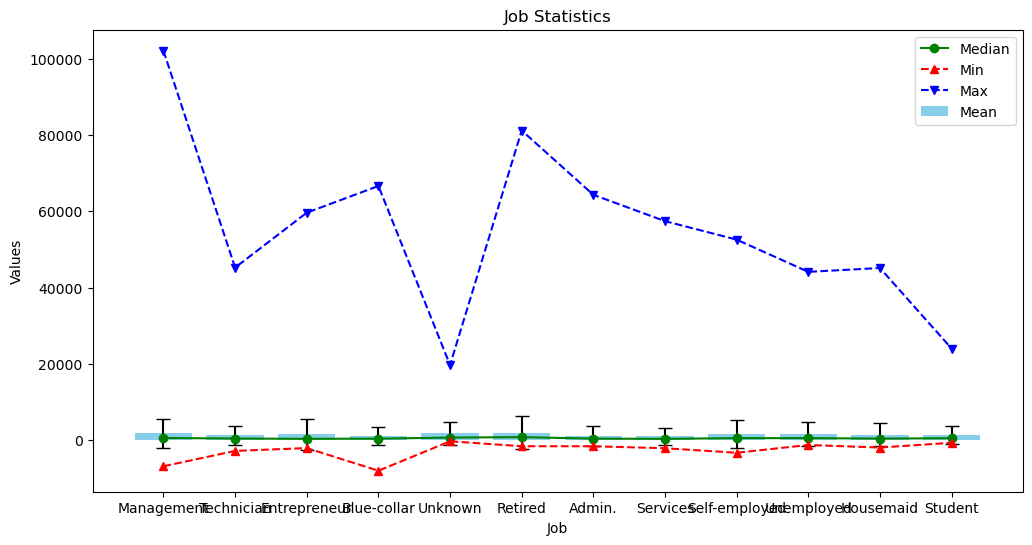

In [24]:
pandas_df = results_df.toPandas()

# Plotting the data
fig, ax = plt.subplots(figsize=(12, 6))

# Plot mean, median, std, min, and max for each job
ax.bar(pandas_df['job'], pandas_df['mean'], yerr=pandas_df['std'], capsize=5, label='Mean', color='skyblue')
ax.plot(pandas_df['job'], pandas_df['median'], marker='o', linestyle='-', color='green', label='Median')
ax.plot(pandas_df['job'], pandas_df['min'], marker='^', linestyle='--', color='red', label='Min')
ax.plot(pandas_df['job'], pandas_df['max'], marker='v', linestyle='--', color='blue', label='Max')

# Customizing the plot
ax.set_xlabel('Job')
ax.set_ylabel('Values')
ax.set_title('Job Statistics')
ax.legend()

# Show plot
plt.show()

In [25]:
# Generate Year column as needed for Timeseries
bank = bank.withColumn(
    "month",
    when(col("month") == "jan", 1)
    .when(col("month") == "feb", 2)
    .when(col("month") == "mar", 3)
    .when(col("month") == "apr", 4)
    .when(col("month") == "may", 5)
    .when(col("month") == "jun", 6)
    .when(col("month") == "jul", 7)
    .when(col("month") == "aug", 8)
    .when(col("month") == "sep", 9)
    .when(col("month") == "oct", 10)
    .when(col("month") == "nov", 11)
    .when(col("month") == "dec", 12)
)

pdf = bank.toPandas()
pdf['year'] = 2008
current_year = 2008

last_month = ''
years = []


for index, row in pdf.iterrows():    
    if row['month'] == 1 and last_month != 1:        
        current_year = current_year + 1         
    last_month = row['month']
    pdf.at[index, 'year'] = current_year

print(f'last year {current_year}')

bank = spark.createDataFrame(pdf)
bank.toPandas().tail(100)


# Create a proper timestamp column
bank = bank.withColumn("date_str", concat_ws("-", col("year"), col("month"), lit(1)))
bank = bank.withColumn("timestamp", date_format(col("date_str"), "yyyy-MM-dd"))

 


last year 2010


In [26]:
bank.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----+----------+-------+----+--------+----------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|index|prev_month|y_index|year|date_str| timestamp|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----+----------+-------+----+--------+----------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|    5|     261|       1|   -1|       0| unknown| no|    0|   unknown|    0.0|2008|2008-5-1|2008-05-01|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|    5|     151|       1|   -1|       0| unknown| no|    1|       may|    0.0|2008|2008-5-1|2008-05-01|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|    5|      76|  

In [27]:
# Describe the dataset
num_rows = bank.count()
num_columns = len(bank.columns)
bank.toPandas().to_csv('bank_marketing_with_timeseries.csv')
# Print basic information about the dataset
print(f"The dataset contains {num_rows} rows and {num_columns} columns.")

The dataset contains 45211 rows and 23 columns.


In [28]:
spark.stop()